In [ ]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

#https://www.kaggle.com/code/enigmak/tabnet-deep-neural-network-for-tabular-data

#from base1 import *
from base2 import *

X_train_1 = pd.read_csv('csv/X_train.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/y_train.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/X_val.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/y_val.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/X_test.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/y_test.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1

runned!
['PCA', 'SMOTE', 'SimpleImputer', 'StandardScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_pca_table', 'np', 'pca_on_train_and_transform_full_data', 'pd', 'plt', 'preprocess_and_apply_smote1', 'remove_outliers_iqr', 'scale_columns1', 'scale_columns2']


<ipython-input-1-31760b59a680>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-1-31760b59a680>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-1-31760b59a680>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Initialize the label encoder
label_encoder = LabelEncoder()
# Fit the label encoder only on the training set
X_train['X140'] = X_train['X140'].astype(str)  # Ensure it's a string type
X_val['X140'] = X_val['X140'].astype(str)      # Ensure it's a string type
X_test['X140'] = X_test['X140'].astype(str)    # Ensure it's a string type
label_encoder.fit(X_train['X140'])
# Apply the label encoding to all datasets
X_train['X141'] = label_encoder.transform(X_train['X140'])
X_val['X141'] = X_val['X140'].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)
X_test['X141'] = X_test['X140'].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)
# Drop the original 'X140' column
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X141")

In [ ]:
# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, precision_recall_curve, auc

# Convert DataFrames to NumPy arrays
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values

In [ ]:
import torch
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import average_precision_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from sklearn.model_selection import train_test_split

In [ ]:
"""def objective(trial):

    hyperparams = {
        'n_a_d': trial.suggest_categorical('n_a_d', [8, 16, 24, 32, 64, 128, 256]),
        'n_steps': trial.suggest_int('n_steps', 3, 10, 1),
        'gamma': trial.suggest_categorical('gamma', [0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]),
        'lambda': trial.suggest_categorical('lambda', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0]),
        'batch_size': trial.suggest_categorical('batch_size', [1024, 2048, 4096, 8192, 16384, 32768]),
        'virtual_batch_size': trial.suggest_categorical('virtual_batch_size', [128, 256, 512, 1024, 2028, 4096]),
        'lr': trial.suggest_categorical('lr', [0.005, 0.01, 0.02, 0.025, 0.03, 0.04, 0.05]),
        'gamma_decay': trial.suggest_categorical('gamma_decay', [0.4, 0.8, 0.9, 0.95]),
        'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
        'batch_momentum': trial.suggest_categorical('batch_momentum', [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]),
    }
    MAX_EPOCHS = 35
    PATIENCE = 5
    model = TabNetClassifier(
        n_d=hyperparams['n_a_d'],
        n_a=hyperparams['n_a_d'],
        gamma=hyperparams['gamma'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr':hyperparams['lr']},
        scheduler_params={"step_size":hyperparams['n_steps'],
                          "gamma":hyperparams['gamma_decay']},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type=hyperparams['mask_type'],
        lambda_sparse=hyperparams['lambda'],
        momentum=hyperparams['batch_momentum'],
        verbose = 0
    )
    model.fit(
        X_train=X_train_np, y_train=y_train,
        eval_set=[(X_train_np, y_train), (X_val_np, y_val)],
        eval_name=['train', 'val'],
        max_epochs=MAX_EPOCHS, 
        patience=PATIENCE,
        batch_size=hyperparams['batch_size'],
        virtual_batch_size=hyperparams['virtual_batch_size'],
        num_workers=0,
        drop_last=False
    )

    val_preds = model.predict(X_val_np)
    
    del model

    return average_precision_score(y_val,val_preds)

study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(multivariate=True, seed=42))

study.optimize(objective, 
               timeout=60*60*6, 
               n_trials=250, 
               gc_after_trial=False)


study.best_params
"""

'def objective(trial):\n\n    hyperparams = {\n        \'n_a_d\': trial.suggest_categorical(\'n_a_d\', [8, 16, 24, 32, 64, 128, 256]),\n        \'n_steps\': trial.suggest_int(\'n_steps\', 3, 10, 1),\n        \'gamma\': trial.suggest_categorical(\'gamma\', [0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]),\n        \'lambda\': trial.suggest_categorical(\'lambda\', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0]),\n        \'batch_size\': trial.suggest_categorical(\'batch_size\', [1024, 2048, 4096, 8192, 16384, 32768]),\n        \'virtual_batch_size\': trial.suggest_categorical(\'virtual_batch_size\', [128, 256, 512, 1024, 2028, 4096]),\n        \'lr\': trial.suggest_categorical(\'lr\', [0.005, 0.01, 0.02, 0.025, 0.03, 0.04, 0.05]),\n        \'gamma_decay\': trial.suggest_categorical(\'gamma_decay\', [0.4, 0.8, 0.9, 0.95]),\n        \'mask_type\': trial.suggest_categorical(\'mask_type\', [\'entmax\', \'sparsemax\']),\n        \'batch_momentum\': trial.suggest_categorical(\'bat

In [ ]:
# Define the model with optimized parameters V1
clf = TabNetClassifier(
    n_d=128,  # Set decision dimension
    n_a=128,  # Set attention dimension
    n_steps=5,  # Number of steps in the network
    gamma=1.0,  # Gamma parameter
    lambda_sparse=1e-06,  # Sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.025),  # Learning rate
    scheduler_params={"step_size": 10, "gamma": 0.95},  # Scheduler decay rate
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',  # Mask type
    momentum=0.95  # Batch normalization momentum
)

# Fit the model
clf.fit(
    X_train_np, y_train,
    eval_set=[(X_train_np, y_train), (X_val_np, y_val)],
    eval_name=['train', 'val'],
    eval_metric=['auc', 'balanced_accuracy'],
    max_epochs=300, patience=60,
    batch_size=2048, virtual_batch_size=1024,
    num_workers=0,
    drop_last=False
)

/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94533 | train_auc: 0.51135 | train_balanced_accuracy: 0.51704 | val_auc: 0.51968 | val_balanced_accuracy: 0.52505 |  0:00:07s
epoch 1  | loss: 0.69453 | train_auc: 0.58795 | train_balanced_accuracy: 0.5309  | val_auc: 0.58718 | val_balanced_accuracy: 0.53541 |  0:00:15s
epoch 2  | loss: 0.55335 | train_auc: 0.60833 | train_balanced_accuracy: 0.53153 | val_auc: 0.60074 | val_balanced_accuracy: 0.52914 |  0:00:22s
epoch 3  | loss: 0.49528 | train_auc: 0.6489  | train_balanced_accuracy: 0.56795 | val_auc: 0.63664 | val_balanced_accuracy: 0.56466 |  0:00:27s
epoch 4  | loss: 0.46868 | train_auc: 0.62668 | train_balanced_accuracy: 0.58076 | val_auc: 0.61434 | val_balanced_accuracy: 0.57908 |  0:00:33s
epoch 5  | loss: 0.46219 | train_auc: 0.62732 | train_balanced_accuracy: 0.60695 | val_auc: 0.6153  | val_balanced_accuracy: 0.59904 |  0:00:39s
epoch 6  | loss: 0.4561  | train_auc: 0.63258 | train_balanced_accuracy: 0.6008  | val_auc: 0.61733 | val_balanced_accuracy: 0.596

/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_pred = clf.predict(X_test_np)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      4071
           1       0.84      0.88      0.86      9379

    accuracy                           0.80     13450
   macro avg       0.77      0.75      0.76     13450
weighted avg       0.80      0.80      0.80     13450



In [ ]:
# Save the trained model
clf.save_model('tabnet_model_V1')
# Later, load the model without retraining
clf_loaded = TabNetClassifier()
clf_loaded.load_model('tabnet_model_V1.zip')
# Verify the loaded model
y_pred_loaded = clf_loaded.predict(X_test_np)
print(classification_report(y_test, y_pred_loaded))

Successfully saved model at tabnet_model_V1.zip


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      4071
           1       0.84      0.88      0.86      9379

    accuracy                           0.80     13450
   macro avg       0.77      0.75      0.76     13450
weighted avg       0.80      0.80      0.80     13450



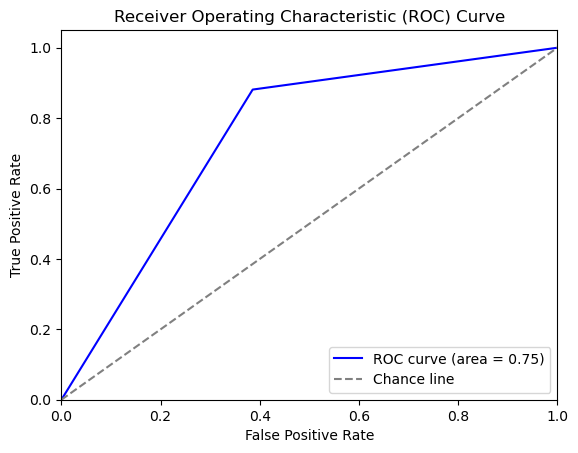

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_test
y_pred_proba = y_pred 
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

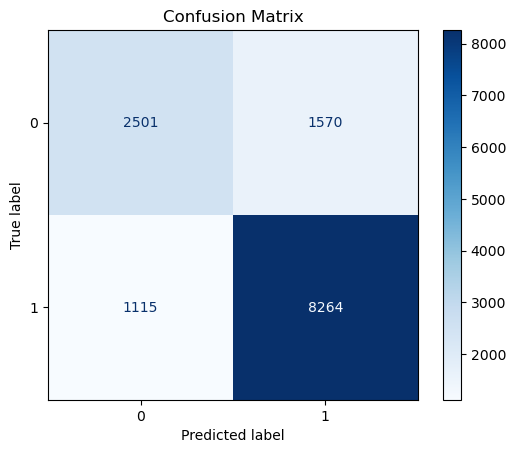

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()